# Продвинутое использование библиоткеки PyTorch: от подготовки данных до визуализации результата.

PyTorch - современная библиотека машинного обучения с открытым исходным кодом, разработанная компанией Facebook. Как и другие популярные библиотеки, такие как TensorFlow и Keras, PyTorch позволяет использовать вычислительную мощность видеокарт, автоматически составлять граф вычислений, дифференцировать и считать его. Но, в отличии от предыдущих библиотек, обладает более гибким функционалом, благодаря тому, что использует динамический граф вычислений.


Сейчас мы пройдем все этапы работы с библотекой PyTorch. Мы затронем далеко не все возможности данной библиотеки, но их хватит, чтобы начать с ней работать. Научимся пользоваться инструментами для подготовки данных, которые делают загрузку данных легкой и уменьшают объем написанного кода. Создадим простую нейросеть, а также класс, который будет ее обучать и который можно будет применить для обучения любой модели, созданный в PyTorch. В конце мы визуализируем результат, чтобы оценить качество обученной модели.

Для начала загрузим нужные библиотеки:

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import copy
import datetime as dt
import pandas as pd
import numpy as np

Воспользуемся генератором датасета `make_moons` из библиотки *sklearn*, который генерирует два класса в двумерном пространстве в виде полумесяца. Добавим немного шума при генерации (переменная `noise`)

In [ ]:
X, y = make_moons(n_samples=150, random_state=33, noise=0.2)

Обернем данные в *pandas.DataFrame* для наглядности:

In [ ]:
df = pd.DataFrame(X, columns=['x1', 'x2'])
df['target'] = y
df.head(5)

,x1,x2,target
0,0.528470,-0.353776,1
1,-0.968172,0.134251,0
2,0.030177,0.961802,0
3,-0.463210,0.997252,0
4,1.854772,0.152242,1


Раделим датасет на тренировочную и тестовую выборки с соотношением 6:4 при помощи функции `train_test_split` из библиотеки *sklearn*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=33)   

Визуализируем получившееся разделение:

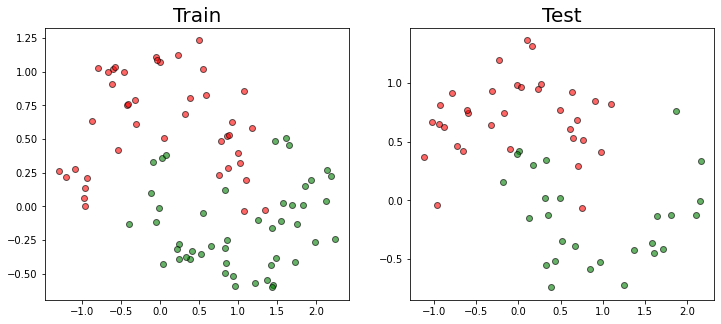

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

ax1.scatter(X_train[:,0][y_train == 0], X_train[:,1][y_train == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax1.scatter(X_train[:,0][y_train == 1], X_train[:,1][y_train == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax1.set_title('Train', fontsize=20)

ax2.scatter(X_test[:,0][y_test == 0], X_test[:,1][y_test == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax2.scatter(X_test[:,0][y_test == 1], X_test[:,1][y_test == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax2.set_title('Test', fontsize=20);

Создадим класс **MyDataset**, который наследуется от класса `torch.utils.data.Dataset`. Переопределим методы \_\_\_len___ и \_\_\_getitem___, чтобы при вызове соответсвующих методов мы получали объем выборки и пару значение-метка.

In [ ]:
class MyDataset(Dataset):
  
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]
  
    def __getitem__(self, index):
        return (self.X[index], self.y[index])

Сделаем нашу игрушечную нейросеть с тремя полносвязными слоями. Между слоями поместим функции активации ReLU, а в третьем слое - сигмоиду.  
Первый слой будет принимать на вход значение *x1* и *x2* и на выходе давать 50 значений. Второй будет принимать 50 значений из первого слоя и подавать 50 значений на третий слой. А уже третий слой будет сжимать эти 50 значений до одного в интервале от 0 до 1 (это будет вероятность отнесения наблюдения к классу "1").

In [ ]:
import torch.nn as nn

ReLU = nn.ReLU()

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 1)

    def forward(self, x):
        x = ReLU(self.fc1(x))
        x = ReLU(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.view(-1)

Создадим экземпляр нашей нейросети и выведем ее структуру. Мы увидим количество слоев, количество параметров на входе и выходе у каждого слоя и наличие\отсутствие свободного члена.

In [ ]:
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=2, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=1, bias=True)
)


Теперь создадим класс, который будет похож на модели, реализованные в библиотеке *sklearn*. Он будет предобрабатывать данные, тренировать нашу нейросеть, запоминать ход обучения и сохранять самую успешную попытку. Описание всех параметров находится внутри класса.

In [ ]:
class Trainer():
    """
    Parameters:
        dataset: пользовательский класс, предобрабатывающий данные
        loss_f: функция потерь
        learning_rate: величина градиентного шага
        epoch_amount: общее количество эпох
        batch_size: размер одного бача
        max_batches_per_epoch: максимальное количество бачей, 
                               подаваемых в модель в одну эпоху
        device: устройство для вычислений
        early_stopping: количество эпох без улучшений до остановки обучения
        optim: оптимизатор
        scheduler: регулятор градиентного шага
        permutate: перемешивание тренировочной выборки перед обучением

    Attributes:
        start_model: необученная модель
        best_model: модель, после обучения
        train_loss: средние значениея функции потерь на тренировочных 
                    данных в каждой эпохе
        val_loss: средние значениея функции потерь на валидационных 
                  данных в каждой эпохе

    Methods:
        fit: обучение модели
        predict: возвращает предсказание обученной моделью

    """
    def __init__(self,  dataset, net, loss_f, learning_rate=1e-3, 
                epoch_amount=10, batch_size=12, 
                max_batches_per_epoch=None,
                device='cpu', early_stopping=10, 
                optim=torch.optim.Adam, 
                scheduler=None, permutate=True):
        
        self.loss_f = loss_f
        self.learning_rate = learning_rate
        self.epoch_amount = epoch_amount
        self.batch_size = batch_size
        self.max_batches_per_epoch = max_batches_per_epoch
        self.device = device
        self.early_stopping = early_stopping
        self.optim = optim
        self.scheduler = scheduler
        self.permutate = permutate
        self.dataset = dataset
        self.start_model = net
        self.best_model = net

        self.train_loss = []
        self.val_loss = []

    def predict(self, X):
        return self.best_model(X)

    def fit(self, X_train, X_test, y_train, y_test):

        Net = self.start_model
            
        device = torch.device(self.device)

        Net.to(self.device)

        optimizer = self.optim(Net.parameters(), lr=self.learning_rate)
        
        if self.scheduler is not None:
            scheduler = self.scheduler(optimizer)

        train = self.dataset(X_train, y_train)
        val = self.dataset(X_test, y_test)  

        train = DataLoader(train, batch_size=self.batch_size, shuffle=self.permutate) 
        val = DataLoader(val, batch_size=self.batch_size, shuffle=False)

        best_val_loss = float('inf')  # Лучшее значение функции потерь на валидационной выборке
                                      # функции потерь на валидационной выборке
        best_ep = 0                   # Эпоха, на которой достигалось лучшее 
                                      # значение функции потерь на валидационной выборке

        for epoch in range(self.epoch_amount): 
            start = dt.datetime.now()
            print(f'Эпоха: {epoch}', end=' ')
            Net.train()
            mean_loss = 0
            batch_n = 0

            for batch_X, target in train:
                if self.max_batches_per_epoch is not None:
                    if batch_n >= self.max_batches_per_epoch:
                        break
                optimizer.zero_grad()

                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)
                loss.backward()
                optimizer.step()

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.train_loss.append(mean_loss)
            print(f'Loss_train: {mean_loss}, {dt.datetime.now() - start} сек')

            Net.eval()
            mean_loss = 0
            batch_n = 0

            with torch.no_grad():
                for batch_X, target in val:
                    if self.max_batches_per_epoch is not None:
                        if batch_n >= self.max_batches_per_epoch:
                            break
                batch_X = batch_X.to(self.device)
                target = target.to(self.device)

                predicted_values = Net(batch_X)
                loss = self.loss_f(predicted_values, target)

                mean_loss += float(loss)
                batch_n += 1
        
            mean_loss /= batch_n
            self.val_loss.append(mean_loss)
            print(f'Loss_val: {mean_loss}')

            if mean_loss < best_val_loss:
                self.best_model = Net
                best_val_loss = mean_loss
                best_ep = epoch
            elif epoch - best_ep > self.early_stopping:
                print(f'{self.early_stopping} без улучшений. Прекращаем обучение...')
                break
            if self.scheduler is not None:
                scheduler.step()
            print()


Прежде всего мы запишем все параметры обучения нашей модели в аттрибуты класса внутри метода \_\_init__. Также инициализируем два аттрибута `train_loss` и `val_loss`, куда будем записывать значение функции потерь на тренировочной и валидационной выборке.  
Затем создаем метод `predict` для удобного использования обученной модели.
После создаем метод `fit`, который будет проивзодить обучение нашей модели. На вход он будет принимать данные для тренировки и валидации. Внтури него помещаем нашу модель на то устройство, на котором собираемся производить вычисления (*'cpu'* - для процессора или *'cuda:*\*', где * номер вашей видеокарты. Это самые распространенные устройства, могут быть и другие).  

Далее указываем оптимизатор `torch.optim`, который будет делать градиентные шаги. Если пользователь ничего не выбрал, будет использоваться `torch.optim.Adam`. Также пользователь может настроить изменение градиентных шагов в ходе обучения с помощью `torch.optim.lr_scheduler`, но это не обязательно.

После этого помещаем данные для тренировочной и валидационной выборки в класс, который создали ранее (в нашем случае это `MyDataset`). Затем подаем наши подготовленные данные в `torch.utils.data.DataLoader`, указывая размер бача (сколько данных будет подаваться в модель за один раз). Классы `torch.utils.data.DataLoader` и `torch.Tensor torch.utils.data.Dataset` (от которого мы унаследовали класс `MyDataset`) служат для упрощения и ускорения загрузки данных и экономии памяти.  
Подготовив данные и создав необходимые переменные, мы начанием процесс обучения. Для этого переводим нашу модель в режим `train`. В этом состоянии будут работать различные методы регуляризации (батч-нормализация, дропаут и т.д). В нашем примере для простоты мы никаких методов регуляризации в нашу модель не добавили.  

Внутри второго цикла мы перебираем батчи, которые нам отдает итератор `train_dataloader`. Каждый батч перемещаем на то устройство, которое мы выбрали в начале. Далее обнуляем градиент у оптимизатора, т.к. в PyTorch по умолчанию градиент будет накапливаться после каждой итерации. После этого делаем основные три действия: совераем прямой проход по нейросети, считаем значение для функции потерь и на основе этого делаем градиентный шаг. Выводим значение функции потерь на тренировочной выборке и время, потраченное на обучение внутри одной эпохи.  
Затем мы считаем значении функции потерь на валидационной выборке. Для этого мы переводим модель в режим `eval` и отключаем рассчет градиента. После этого делаем то же, что и при обучении, но без градиентного шага. Результат функции потерь также выводим на экран. Если результат функции потерь на валидационной выборке оказался лучше, чем был, то мы сохраняем текущую модель в переменную `best_model`.  
Все эти шаги повторяются столько раз, сколько мы указали в `epoch_amount`, либо до тех пор пока значение функции потерь на валидационной выборке не перестанет изменяться (если указан параметр `early_stopping`).  
На выходе мы получим модель, которая лучшим образом показала себя на валидационной выборке, значение функции потерь на этой модели и два списка со значением функции потерь в ходе обучения на тренировочных и валидационных данных.


Теперь настало время опробовать класс на нашем датасете. В качестве функции потерь выберем бинарную кросс-энтропию `torch.nn.BCELoss`, а в качестве оптимизатора - стохастический градиентный спуск `torch.optim.SGD`.  
Запишем все выбранные параметры в словарь и подадим его методу `fit`.

In [ ]:
params = {
    'dataset': MyDataset,
    'net': net,
    'epoch_amount': 1000, 
    'learning_rate': 1e-2,
    'early_stopping': 25,
    'loss_f': nn.BCELoss(),
    'optim': torch.optim.SGD,
}

In [ ]:
clf = Trainer(**params)
clf.fit(X_train, X_test, y_train, y_test)

Осталось визуализировать полученный результат. 

Построим график изменения значения функции потерь на тренировочной и валидационной выборке от количетсва эпох.

In [ ]:
def plot_loss(Loss_train, Loss_val):
    plt.figure(figsize=(12, 5))
    plt.plot(range(len(Loss_train)), Loss_train, color='orange', label='train', linestyle='--')
    plt.plot(range(len(Loss_val)), Loss_val, color='blue', marker='o', label='val')
    plt.legend()
    plt.show()

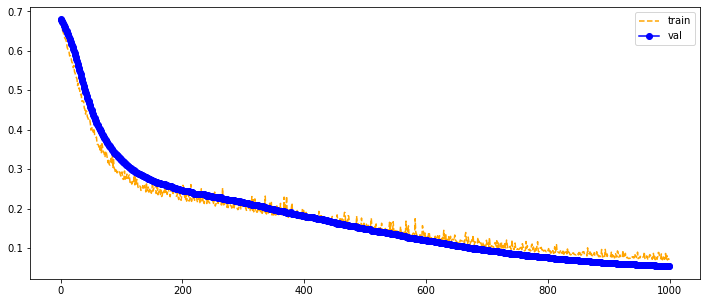

In [ ]:
plot_loss(clf.train_loss, clf.val_loss)

Визуализируем границу разделения. 

In [ ]:
def make_meshgrid(x1, x2, h=.02):
    x1_min, x1_max = x1.min() - 2, x1.max() + 2
    x2_min, x2_max = x2.min() - 2, x2.max() + 2
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h), np.arange(x2_min, x2_max, h))
    return xx1, xx2

def plot_contours(ax, xx1, xx2, **params):
    C = clf.predict(torch.Tensor(np.c_[xx1.ravel(), xx2.ravel()])).detach().numpy()
    C = C.reshape(xx1.shape)
    out = ax.contourf(xx1, xx2, C, **params)
    return out

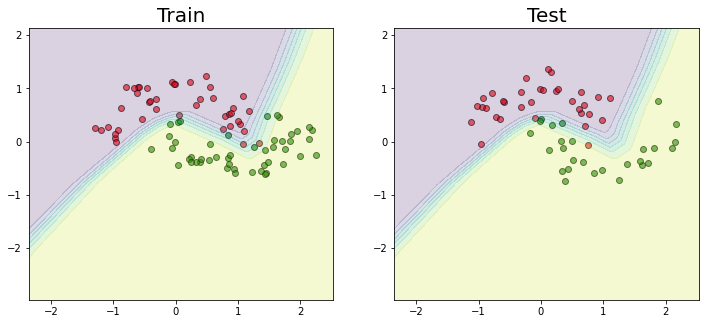

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

xx1, xx2 = make_meshgrid(X[0], X[1])

ax1.scatter(X_train[:,0][y_train == 0], X_train[:,1][y_train == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax1.scatter(X_train[:,0][y_train == 1], X_train[:,1][y_train == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax1.set_title('Train', fontsize=20)
plot_contours(ax1, xx1, xx2, alpha=0.2)

ax2.scatter(X_test[:,0][y_test == 0], X_test[:,1][y_test == 0], c='red', marker='o', edgecolors = 'black', alpha = 0.6)
ax2.scatter(X_test[:,0][y_test == 1], X_test[:,1][y_test == 1], c='green', marker = 'o', edgecolors = 'black', alpha = 0.6)
ax2.set_title('Test', fontsize=20)
plot_contours(ax2, xx1, xx2, alpha=0.2);

Желтым цветом показана область, где вероятность встретить точку из класса "1" максимальна. Соответственно, для точки из класса "0" вероятность максимальна в красной области.  
Как мы видим, граница разделения получилась нелинейной, т.к. в нейросетях используются нелинейные функции активации.